<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Арсений Кравченко, DS team lead @ Juno. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №6
## <center> Исследование признаков на примере поездок такси в Чикаго

Чтобы начать работу, нужно скачать данные о поездках на такси в Чикаго за первые три месяца 2016 года, а также файл `column_remapping.json` и положить их в папку `data` в репозитории (комитить эти файлы не рекомендуется – они немаленькие).

Данные доступны на Kaggle в [этом](https://www.kaggle.com/chicago/chicago-taxi-rides-2016) соревновании. Описание данных [тут](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1yQkyn-FoutHi5BzSHq_YVNdN6ZGJe6za4y018nAi5UM).

In [2]:
RANDOM_STATE = 42
N_FOLDS = 5

In [3]:
import json
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Будем играть с предсказанием цены, `fare` будет целевой переменной, тогда `trip_total` является ликом по отношению к ней – выкинем этот признак.

In [4]:
dataset_files = sorted(glob('../../data/chicago_taxi_trips_2016_*.csv'))
assert len(dataset_files) == 3

df = pd.concat(map(pd.read_csv, dataset_files))
df.drop('trip_total', axis=1, inplace=True)
target = df.pop('fare')

Загрузим словарь, ключи которого – названия признаков, а значения – опять же, словари, отображающие индексы уникальных значений признака в сами значения. Если звучит путано, посмотрите, например, на признак `pickup_longitude` в исходных данных и в словаре `column_remapping`.

In [5]:
with open('../../data/column_remapping.json') as json_file:
    column_remapping = json.load(json_file)

In [6]:
column_remapping.keys()

dict_keys(['taxi_id', 'company', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [7]:
df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,tips,tolls,extras,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.40,NaN,NaN,24.0,24.0,0.00,0.0,0.0,Cash,107.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,240.0,0.70,NaN,NaN,NaN,NaN,4.45,0.0,0.0,Credit Card,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,0.0,0.00,NaN,NaN,NaN,NaN,5.00,0.0,0.0,Credit Card,119.0,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.10,NaN,NaN,6.0,6.0,0.00,0.0,0.0,Cash,NaN,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,480.0,2.71,NaN,NaN,32.0,NaN,0.00,0.0,0.0,Cash,NaN,385.0,478.0,NaN,NaN


In [7]:
assert df.shape == (5432105, 18)

In [8]:
target[df.tips.isnull()].isnull().sum()

57

In [9]:
df.trip_miles.max()

3280.0

In [13]:
#column_remapping['dropoff_latitude']

**<font color='red'>Вопрос №1.</font> Какой из признаков является вещественным и из предобработки требует только заполнения/удаления пропусков? **

- dropoff_latitude
- **tips - OK**
- company
- pickup_census_tract

**<font color='red'>Вопрос №2.</font> Какие методы предобработки целевой переменной могут быть уместны, судя по графику? **

- возведение в n-ую степень, n >= 2 
- ride2vec
- **логарифмирование - OK**
- никакие

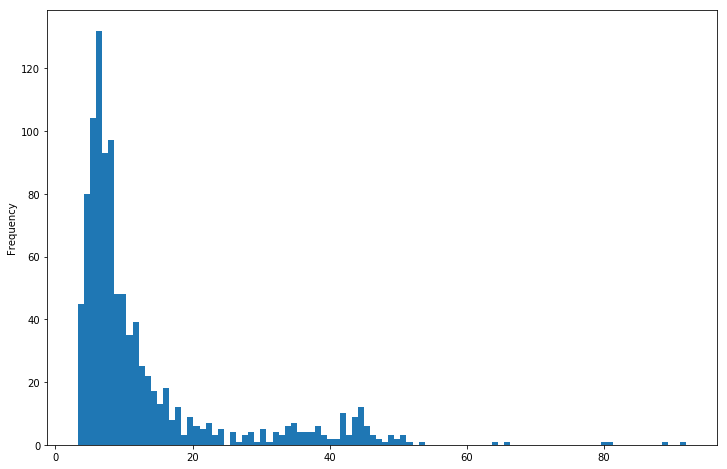

In [11]:
target.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100);

**<font color='red'>Вопрос №3.</font> Каково максимальное расстояние (`great-circle distance` из библиотеки `geopy`, в км) между точками `pickup` и `dropoff`?** <br>(Для ускорения подсчета можно использовать `joblib`)
- 27.23
- 19.91
- 23.52
- **43.66 - OK**

In [12]:
# !pip install geopy
# !pip install joblib

In [13]:
from joblib import Parallel, delayed

In [12]:
# %%timeit
# # ПРИМЕР

# from math import sqrt
# np.max((Parallel(n_jobs=2)(delayed(sqrt)(i**3) for i in range(10))))

1 loop, best of 3: 1.45 s per loop


In [8]:
from geopy.distance import great_circle

In [14]:
# # ПРИМЕР
# newport_ri = (41.49008, -71.312796)
# cleveland_oh = (41.499498, -81.695391)
# print(great_circle(newport_ri, cleveland_oh).km)

864.45676162966


In [9]:
pickup_dropoff = df[['pickup_latitude', 'pickup_longitude', 
                     'dropoff_latitude', 'dropoff_longitude']].dropna()

In [17]:
%%timeit
# пример расчета 1 дистанции
def coord(coord, i):
    return column_remapping[coord][str(int(pickup_dropoff[coord].iloc[i]))]
i = 2
pickup_coord = (coord('pickup_latitude', i), 
                    coord('pickup_longitude', i))
dropoff_coord = (coord('dropoff_latitude', i), 
                    coord('dropoff_longitude', i))
    
pickup_dropoff['distance'].iloc[i] = great_circle(pickup_coord, dropoff_coord).km 

The slowest run took 32.95 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 4.4 ms per loop


In [73]:
%%time
# максимальная дистанция без запоминания всех дистанций
def coord(coord, i):
    return column_remapping[coord][str(int(pickup_dropoff[coord].iloc[i]))]

#pickup_dropoff['distance'] = pd.Series(np.zeros(len(pickup_dropoff)))
max_distance = 0
for i in range(len(pickup_dropoff)):
    pickup_coord = (coord('pickup_latitude', i), 
                    coord('pickup_longitude', i))
    dropoff_coord = (coord('dropoff_latitude', i), 
                    coord('dropoff_longitude', i))
    
    #pickup_dropoff['distance'].iloc[i] = great_circle(pickup_coord, dropoff_coord).km
    distance = great_circle(pickup_coord, dropoff_coord).km
    if distance > max_distance:
        max_distance = distance

Wall time: 9min 10s


In [74]:
max_distance

43.662892734777216

### более продвинутая реализация с учетом авторского решения
(распараллеливание запустить не удалось)

In [10]:
import tqdm

for col in pickup_dropoff.columns:
    pickup_dropoff[col] = pickup_dropoff[col].apply(lambda x: column_remapping[col].get(str(int(x))))

def dist(row):
    return great_circle((row['pickup_latitude'], row['pickup_longitude']),
                        (row['dropoff_latitude'], row['dropoff_longitude'])).km
    

pickup_dropoff['distance'] = pd.Series([dist(row) 
                                        for i, row in tqdm.tqdm_notebook(pickup_dropoff.iterrows(), total=len(pickup_dropoff))])

In [11]:
pickup_dropoff.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance
0,41.901206994,-87.676355989,41.901206994,-87.676355989,0.000000
3,41.944226601,-87.655998182,41.944226601,-87.655998182,0.000000
5,41.899602111,-87.633308037,41.96581197,-87.655878786,1.524371
7,41.953582125,-87.72345239,41.953582125,-87.72345239,4.737123
8,41.892507781,-87.626214906,41.884987192,-87.620992913,1.832034


In [12]:
pickup_dropoff['distance'].max()

43.662892734777074

Давайте обучим простую модель, прежде чем пробовать добавлять признаки.

In [18]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    y_data = target.fillna(0)
    
kfold = KFold(n_splits=N_FOLDS, shuffle=True)

# cross_val_score максимизирует метрику, так что вместо 
# минимизации MSE по факту происходит максимизация отрицательного MSE.
# Поэтому выведем модуль среднего значения метрики на кросс-валидации.
print(np.abs(cross_val_score(LinearRegression(), 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

840.827059003
Wall time: 27.1 s


**<font color='red'>Вопрос №4.</font> В ячейке выше допущено несколько ошибок и неаккуратных действий.
Что из перечисленных НЕ является проблемой, влияющей на настоящее качество модели? **

- **не зафиксирован random seed - OK**
- признаки разной размерности не нормированы
- взята малая подвыборка признаков
- пропуски в целевой переменной заполнены неуместным значением по умолчанию

Слегка модифицируем обработку данных.

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

877.71181818822151

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

for feat in ['tips', 'tolls', 'trip_seconds', 'trip_miles']:
    
    pipeline = make_pipeline(StandardScaler(),
                             LinearRegression())

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    print('без %s: MSE = %f' % (feat, np.abs(cross_val_score(pipeline,
                    X=X_data.drop(feat, axis=1).values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error') \
        .mean())))

без tips: MSE = 908.722836
без tolls: MSE = 719.773903
без trip_seconds: MSE = 905.274108
без trip_miles: MSE = 879.313958


**<font color='red'>Вопрос №5.</font> Какой из признаков нужно убрать, чтобы качество модели улучшилось значительнее всего?**

- tips
- **tolls - OK** 
- trip_seconds
- trip_miles
- ни один из вышеперечисленных

Давайте построим модель на двух признаках (время поездки и пройденное расстояние) и попробуем добавить еще один признак, связанный с датой. 

In [21]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['trip_start_timestamp', 'trip_seconds', 'trip_miles']]
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

timestamp = pd.to_datetime(X_data.pop('trip_start_timestamp'))

t1 = timestamp.apply(lambda x: x.dayofweek)
t2 = timestamp.apply(lambda x: 1 if x.dayofweek in (5, 6) else 0)
t3 = timestamp.apply(lambda x: x.hour)
t4 = timestamp.apply(lambda x: x.dayofweek * 24 + x.hour)

Wall time: 2min 4s


поэкспериментируем с форматом Timestamp

In [28]:
X_data1 = df[['trip_start_timestamp', 'trip_seconds', 'trip_miles']]
timestamp1 = pd.to_datetime(X_data1.pop('trip_start_timestamp'))

In [35]:
timestamp1.iloc[1]

Timestamp('2016-01-22 09:30:00')

In [33]:
timestamp1.iloc[1].hour

9

In [36]:
pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

748.90456534507416

In [38]:
# рассчитаем метрику без дополнительного временнОго признака (для сравнения)
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
scoring_without_time = np.abs(cross_val_score(pipeline,
                        X=X_data.values,
                        y=y_data,
                        cv=kfold,
                        scoring='neg_mean_squared_error') \
    .mean())

for i, t in enumerate((t1, t2, t3, t4)):
    X_data_changed = X_data.copy()
    X_data_changed['time'] = t
    
    # Ваш код здесь
    pipeline = make_pipeline(StandardScaler(), 
                             LinearRegression())
    pipeline1 = make_pipeline(StandardScaler(), 
                             LinearRegression())

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    print('t%i: MSE (без time) = %f, MSE (c time) = %f' %(i+1, scoring_without_time, 
                    np.abs(cross_val_score(pipeline1,
                    X=X_data_changed.values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error').mean())))

t1: MSE (без time) = 748.904565, MSE (c time) = 748.830518
t2: MSE (без time) = 748.904565, MSE (c time) = 748.894393
t3: MSE (без time) = 748.904565, MSE (c time) = 748.904921
t4: MSE (без time) = 748.904565, MSE (c time) = 748.829605


In [24]:
X_data_changed = X_data.copy()
X_data_changed['time'] = t3
X_data_changed.head(10)

,trip_seconds,trip_miles,time
0,180.0,0.40,6
1,240.0,0.70,9
2,0.0,0.00,21
3,480.0,1.10,17
4,480.0,2.71,5
5,1080.0,6.20,18
6,1500.0,18.40,4
7,60.0,0.20,4
8,180.0,0.00,11
9,0.0,0.00,21


** <font color='red'>Вопрос №6.</font> Какие выводы можно сделать? **

- новые признаки не улучшают модель, т.к. автор намеренно совершил техническую ошибку
- **новые признаки не улучшают модель, т.к. такова природа данных -OK**
- новые признаки улучшают модель всего на 3%
- новые признаки улучшают модель всего на 7%

** <font color='red'>Вопрос №7</font>. Отвлечемся и пофантазируем. Представим, что ввели закон, обязывающий пассажиров такси фотографировать своего водителя перед каждой поездкой и после каждой поездки; к нам, в дополнение к текущему датасету, попали эти фотографии. Как _нельзя_ было бы использовать их в предсказании цены поездки? **

- **извлечь признаки водителя при помощи предобученной нейронной сети, получив значения на одном из последних полносвязных слоев - OK**
- использовать метаданные о модели телефона пассажира
- использовать геотег с обеих фотографий
- использовать время съемки

Давайте попробуем преобразовать один из признаков, чтобы избавиться от "длинного хвоста" справа.

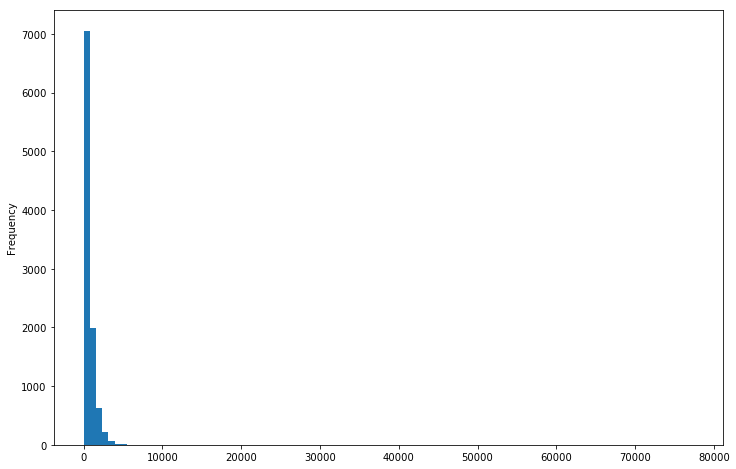

In [40]:
df_tmp = df.copy()
df_tmp = df_tmp[df_tmp.trip_seconds > 0]
seconds = df_tmp.trip_seconds

seconds.sample(10000).plot(kind='hist', bins=100);

In [41]:
seconds.min()

60.0

Wall time: 487 ms


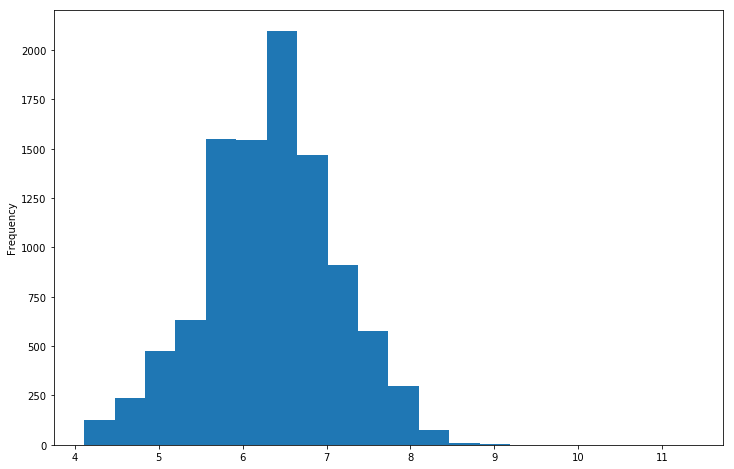

In [136]:
%%time
seconds.sample(10000).apply(lambda x: 
                            np.log(x + 1)).plot(kind='hist', bins=20);

Wall time: 479 ms


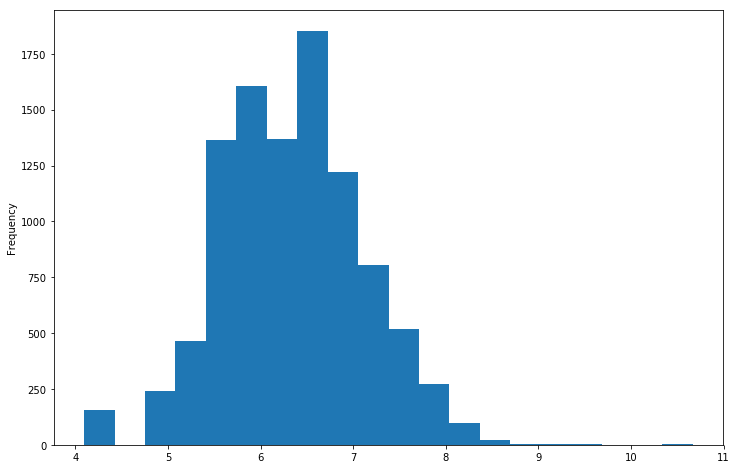

In [137]:
%%time
seconds.sample(10000).apply(lambda x: 
                            np.log(x)).plot(kind='hist', bins=20);

**<font color='red'>Вопрос №8.</font> Зачем в предыдущей ячейке используется `np.log(x + 1)`, а не просто `np.log`?**

- **чтобы запутать читателей - OK**
- чтобы получить бимодальное распределение
- для скорости вычисления
- во избежание `ValueError`